In [3]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
import pandas as pd
import yaml
from scipy.special import expit

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Compute the area of the intersection rectangle
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    union_area = box1_area + box2_area - intersection_area
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

def non_max_suppression(boxes, scores, iou_threshold=0.5):
    sorted_indices = np.argsort(scores)[::-1]
    keep = []
    
    while len(sorted_indices) > 0:
        current_idx = sorted_indices[0]
        keep.append(current_idx)
        
        remaining_indices = sorted_indices[1:]
        filtered_indices = []
        
        for idx in remaining_indices:
            iou = compute_iou(boxes[current_idx], boxes[idx])
            if iou <= iou_threshold:
                filtered_indices.append(idx)
        
        sorted_indices = np.array(filtered_indices)
    
    return keep
    

In [4]:
# — load class names
cfg = yaml.safe_load(open('models\YOLO_x_nano\st_yolo_x_nano_192_0.33_0.25_config.yaml'))
class_names = cfg['dataset']['class_names']

# - load model
model = tf.keras.models.load_model('models\YOLO_x_nano\st_yolo_x_nano_192_0.33_0.25.h5')
print("expects:", model.input_shape, model.input.dtype)

# - view all model layers
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name} - output shape: {layer.output_shape}")

expects: (None, 192, 192, 3) <dtype: 'float32'>
0: input_1 - output shape: [(None, 192, 192, 3)]
1: st_conv - output shape: (None, 96, 96, 12)
2: st_bn - output shape: (None, 96, 96, 12)
3: st_relu6 - output shape: (None, 96, 96, 12)
4: stem_conv - output shape: (None, 96, 96, 16)
5: stem_bn - output shape: (None, 96, 96, 16)
6: stem_relu6 - output shape: (None, 96, 96, 16)
7: stack1_dw_conv - output shape: (None, 48, 48, 16)
8: stack1_dw_bn - output shape: (None, 48, 48, 16)
9: stack1_dw_relu6 - output shape: (None, 48, 48, 16)
10: stack1_conv - output shape: (None, 48, 48, 32)
11: stack1_bn - output shape: (None, 48, 48, 32)
12: stack1_relu6 - output shape: (None, 48, 48, 32)
13: stack1_deep_conv - output shape: (None, 48, 48, 16)
14: stack1_deep_bn - output shape: (None, 48, 48, 16)
15: stack1_deep_relu6 - output shape: (None, 48, 48, 16)
16: stack1_block1_1_conv - output shape: (None, 48, 48, 16)
17: stack1_block1_1_bn - output shape: (None, 48, 48, 16)
18: stack1_block1_1_relu6 - 

(1, 192, 192, 3) float32 0.0 1.0


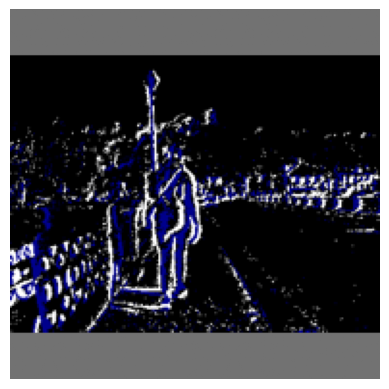

In [7]:
# Load the image
img = Image.open('val_rgb/frame0002556.png').convert('RGB')
# Resize while maintaining aspect ratio by padding
desired_size =  model.input_shape[1]
img = ImageOps.pad(img, (desired_size, desired_size), color=(114, 114, 114))

# Convert to numpy array and scale to [0, 1]
img_array = np.asarray(img, dtype=np.float32) / 255.0

# If model expects batch dimension, add it:
img_array = img_array[np.newaxis, ...] # shape: (1, 192, 192, 3)

print(img_array.shape, img_array.dtype, img_array.min(), img_array.max())
plt.imshow(img_array[0])
plt.axis('off')
plt.show()

In [8]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_array)

In [9]:
p3, p4, p5 = model.predict(img_array)
p3, p4, p5 = p3[0], p4[0], p5[0]

print("p3 random element: ", p3[0, 0])
all_boxes = []
all_boxes_flatten = []
prediction_sources = []
multw = 0
multh = 0

for i, p in enumerate([p3, p4, p5]):
    stride = img_array.shape[1]/p.shape[0]
    print(stride)
    
    p[..., [0,1,4,5]] = expit(p[..., [0,1,4,5]])
    H, W = p.shape[:2]
    
    gx, gy = np.meshgrid(np.arange(W), np.arange(H))
    # decode centers
    p[..., 0] = (p[..., 0] + gx) * stride
    p[..., 1] = (p[..., 1] + gy) * stride
    # decode size
    
    p[..., [2,3]] = np.exp(p[..., [2,3]]) * model.input_shape[1]/2
    
    all_boxes.append(p)
    flattened = p.reshape(-1, p.shape[-1])
    all_boxes_flatten.append(flattened)
    prediction_sources.extend([f"p{i+3}"] * flattened.shape[0]) 
    print(all_boxes_flatten[i].shape)

all_boxes_flatten = np.concatenate(all_boxes_flatten, axis=0)

p3 random element:  [-0.48219186 -0.45557946 -3.1608343  -3.0046303  -6.904922   -0.39033228]
8.0
(576, 6)
16.0
(144, 6)
32.0
(36, 6)


In [10]:
por = 1
# Calculate the maximum and minimum for each of the 6 elements
max_values = np.max(all_boxes[por], axis=(0, 1))
min_values = np.min(all_boxes[por], axis=(0, 1))
scores = all_boxes[por][..., 4] * all_boxes[por][..., 5]
max_values = np.append(max_values, np.max(scores))
min_values = np.append(min_values, np.min(scores))

element_names = ["x", "y", "height", "width", "Pc", "c1", "score"]
# Print the results
for i in range(7):
    print(f"{element_names[i]}: Max = {max_values[i]}, Min = {min_values[i]}")

x: Max = 187.1309356689453, Min = 4.362861156463623
y: Max = 187.6026611328125, Min = 4.195206165313721
height: Max = 88.89674377441406, Min = 2.279435396194458
width: Max = 115.86568450927734, Min = 2.0312488079071045
Pc: Max = 0.21613846719264984, Min = 0.00018251394794788212
c1: Max = 0.9235489368438721, Min = 0.45372000336647034
score: Max = 0.10419626533985138, Min = 0.00011732153507182375


In [11]:
for i in range(all_boxes[por].shape[0]):  # Iterate over rows
    for j in range(all_boxes[por].shape[1]):  # Iterate over columns
        grid_cell_data = all_boxes[por][i, j]  # Shape: (6,)
        df = pd.DataFrame([grid_cell_data], columns=[f"{element_names[k]}" for k in range(0, 6)])
        print(f"Grid Cell ({i}, {j}): Score = {grid_cell_data[4]*grid_cell_data[5]}")
        print(df)
        print("-" * 50)

Grid Cell (0, 0): Score = 0.0010211002081632614
          x         y    height     width        Pc        c1
0  6.765224  6.960028  6.722445  8.841498  0.001678  0.608456
--------------------------------------------------
Grid Cell (0, 1): Score = 0.00037430948577821255
           x         y     height    width       Pc       c1
0  23.248764  5.091275  28.301018  5.42043  0.00051  0.73417
--------------------------------------------------
Grid Cell (0, 2): Score = 0.00033429230097681284
           x         y     height     width        Pc        c1
0  40.710529  4.841704  38.263809  5.512637  0.000427  0.782299
--------------------------------------------------
Grid Cell (0, 3): Score = 0.000289075484033674
           x         y     height     width        Pc        c1
0  56.680351  4.717852  43.417744  5.356135  0.000412  0.700945
--------------------------------------------------
Grid Cell (0, 4): Score = 0.00022849210654385388
           x         y     height     width       Pc

In [12]:
scores = all_boxes_flatten[:, 4] * all_boxes_flatten[:, 5] 
top5_idxs = np.argsort(scores)[-5:][::-1]

# 2. Extract those boxes and their scores
top5_boxes  = all_boxes_flatten[top5_idxs]   # shape (5,6)
top5_scores = scores[top5_idxs]      # shape (5,)
top5_sources = [prediction_sources[idx] for idx in top5_idxs]  # Get the sources

# 3. (Optional) print them out
for rank, (box, score, source) in enumerate(zip(top5_boxes, top5_scores, top5_sources), start=1):
    x_center, y_center, w, h, obj, cls = box
    print(f"{rank}: score={score:.3f}, source={source}, center=({x_center:.1f},{y_center:.1f}), "
          f"size=({w:.1f}*{h:.1f})")

1: score=0.155, source=p5, center=(86.1,111.7), size=(39.1*99.6)
2: score=0.146, source=p5, center=(106.8,113.1), size=(64.6*106.1)
3: score=0.136, source=p3, center=(107.5,124.1), size=(58.8*87.5)
4: score=0.112, source=p3, center=(84.3,116.3), size=(34.8*92.9)
5: score=0.104, source=p4, center=(87.4,119.5), size=(37.0*99.2)


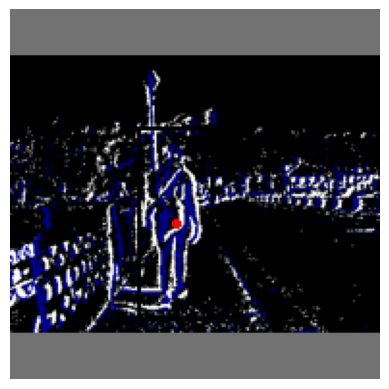

In [13]:
best_idx = top5_idxs[0]
best_box = all_boxes_flatten[best_idx] 

# --- Convert to corner coords ---
cx, cy, w, h = best_box[:4]
x1, y1 = cx - w/2, cy - h/2
x2, y2 = cx + w/2, cy + h/2

# --- Draw the box ---
img_with_box = img.copy()
draw = ImageDraw.Draw(img_with_box)
draw.rectangle([(int(x1), int(y1)), (int(x2), int(y2))],
               outline="black", width=2)
# Draw a red circle at (x1, y1)
circle_radius = 2  # Radius of the circle
draw.ellipse(
    [(int(cx) - circle_radius, int(cy) - circle_radius), 
     (int(cx) + circle_radius, int(cy) + circle_radius)],
    outline="red", width=2
)
plt.imshow(img_with_box)
plt.axis('off')
plt.show()

In [16]:
threshold = 0.15
valid_idxs = np.where(scores > threshold)[0]
filtered_boxes = all_boxes_flatten[valid_idxs]
filtered_scores = scores[valid_idxs]

x_centers, y_centers, widths, heights = filtered_boxes[:, 0], filtered_boxes[:, 1], filtered_boxes[:, 2], filtered_boxes[:, 3]
x1 = x_centers - widths / 2
y1 = y_centers - heights / 2
x2 = x_centers + widths / 2
y2 = y_centers + heights / 2

boxes = np.stack([x1, y1, x2, y2], axis=1)

selected_indices = non_max_suppression(boxes, filtered_scores)
final_boxes = boxes[selected_indices]
final_scores = filtered_scores[selected_indices]
final_sources = [prediction_sources[idx] for idx in valid_idxs[selected_indices]]

for rank, (box, score, source) in enumerate(zip(final_boxes, final_scores, final_sources), start=1):
    x1, y1, x2, y2 = box
    print(f"{rank}: score={score:.3f}, source={source}, top_corner=({x1:.1f},{y1:.1f}), "
          f"bottom_corner=({x2:.1f}*{y2:.1f})")

1: score=0.155, source=p5, top_corner=(66.5,61.9), bottom_corner=(105.6*161.5)


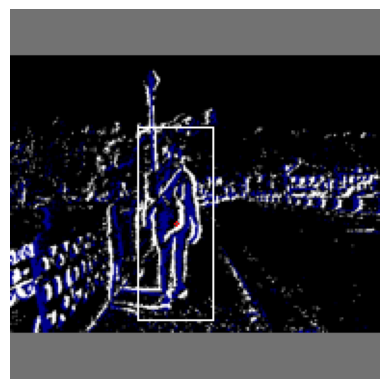

In [17]:
img_with_box = img.copy()
draw = ImageDraw.Draw(img_with_box)
circle_radius = 1

for box in final_boxes:
    cx = (box[0] + box[2]) / 2
    cy = (box[1] + box[3]) / 2
    x1, y1, x2, y2 = box
    draw.rectangle([(int(x1), int(y1)), (int(x2), int(y2))],
               outline="white", width=1)
    draw.ellipse(
        [(int(cx) - circle_radius, int(cy) - circle_radius), 
        (int(cx) + circle_radius, int(cy) + circle_radius)],
        outline="red", width=1
    )

plt.imshow(img_with_box)
plt.axis('off')
plt.show()

Input details: [{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 192, 192,   3]), 'shape_signature': array([ -1, 192, 192,   3]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:2', 'index': 376, 'shape': array([1, 6, 6, 6]), 'shape_signature': array([-1,  6,  6,  6]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:0', 'index': 328, 'shape': array([ 1, 24, 24,  6]), 'shape_signature': array([-1, 24, 24,  6]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'z

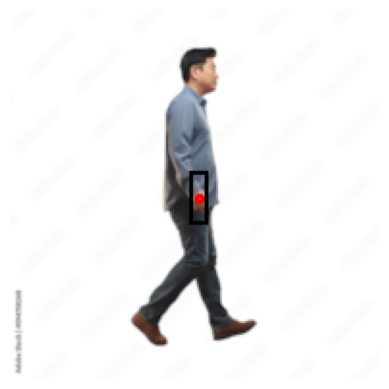

In [29]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="models\\YOLO_x_nano\\st_yolo_x_nano_192_0.33_0.25_int8.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Print input and output details for debugging
print("Input details:", input_details)
print("Output details:", output_details)

# Preprocess the image (already in your notebook)
img = Image.open('testImages/YOLO_x_nano/man2.png').convert('RGB')
desired_size = 192
img = ImageOps.pad(img, (desired_size, desired_size), color=(0, 0, 0))
img_array = np.asarray(img, dtype=np.uint8)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], img_array)

# Run inference
interpreter.invoke()

# Retrieve the output tensors
outputs = [interpreter.get_tensor(output['index']) for output in output_details]

# Post-process the outputs (similar to your existing code)
p3, p4, p5 = outputs
p3, p4, p5 = p3[0], p4[0], p5[0]

print("p3 random element: ", p3[0, 0])
all_boxes = []
all_boxes_flatten = []
prediction_sources = []

for i, p in enumerate([p3, p4, p5]):
    stride = img_array.shape[1] / p.shape[0]
    print(stride)

    p[..., [0, 1, 4, 5]] = expit(p[..., [0, 1, 4, 5]])
    H, W = p.shape[:2]

    gx, gy = np.meshgrid(np.arange(W), np.arange(H))
    # Decode centers
    p[..., 0] = (p[..., 0] + gx) * stride
    p[..., 1] = (p[..., 1] + gy) * stride
    # Decode size
    p[..., [2, 3]] = np.exp(p[..., [2, 3]]) * stride

    all_boxes.append(p)
    flattened = p.reshape(-1, p.shape[-1])
    all_boxes_flatten.append(flattened)
    prediction_sources.extend([f"p{i+3}"] * flattened.shape[0])
    print(all_boxes_flatten[i].shape)

all_boxes_flatten = np.concatenate(all_boxes_flatten, axis=0)

scores = all_boxes_flatten[:, 4] * all_boxes_flatten[:, 5] 
top5_idxs = np.argsort(scores)[-5:][::-1]

# 2. Extract those boxes and their scores
top5_boxes  = all_boxes_flatten[top5_idxs]   # shape (5,6)
top5_scores = scores[top5_idxs]      # shape (5,)
top5_sources = [prediction_sources[idx] for idx in top5_idxs]  # Get the sources

# 3. (Optional) print them out
for rank, (box, score, source) in enumerate(zip(top5_boxes, top5_scores, top5_sources), start=1):
    x_center, y_center, w, h, obj, cls = box
    print(f"{rank}: score={score:.3f}, source={source}, center=({x_center:.1f},{y_center:.1f}), "
          f"size=({w:.1f}*{h:.1f})")

best_idx = top5_idxs[3]
best_box = all_boxes_flatten[best_idx] 

# --- Convert to corner coords ---
cx, cy, w, h = best_box[:4]
x1, y1 = cx - w/2, cy - h/2
x2, y2 = cx + w/2, cy + h/2

# --- Draw the box ---
img_with_box = img.copy()
draw = ImageDraw.Draw(img_with_box)
draw.rectangle([(int(x1), int(y1)), (int(x2), int(y2))],
               outline="black", width=2)
# Draw a red circle at (x1, y1)
circle_radius = 2  # Radius of the circle
draw.ellipse(
    [(int(cx) - circle_radius, int(cy) - circle_radius), 
     (int(cx) + circle_radius, int(cy) + circle_radius)],
    outline="red", width=2
)
plt.imshow(img_with_box)
plt.axis('off')
plt.show()
